<a href="https://colab.research.google.com/github/sivaprakasha-datascientist/60-60-60-Python-Challenge/blob/main/Cat_bag_pack_Siva_Prakash_Updated_code_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s5e2_path = kagglehub.competition_download('playground-series-s5e2')

print('Data source import complete.')


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold,GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [ ]:
import pandas as pd

# Load datasets
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv").drop("id", axis=1)
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv").drop("id", axis=1)
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e2/sample_submission.csv")  # Fixed path


In [ ]:
train_df.head()


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [ ]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 22.9+ MB


In [ ]:
num_col = [i for i in train_df.columns if train_df[i].dtype == 'float64']
cat_col = [i for i in train_df.columns if i not in num_col]
print(len(num_col), len(cat_col))


3 7


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


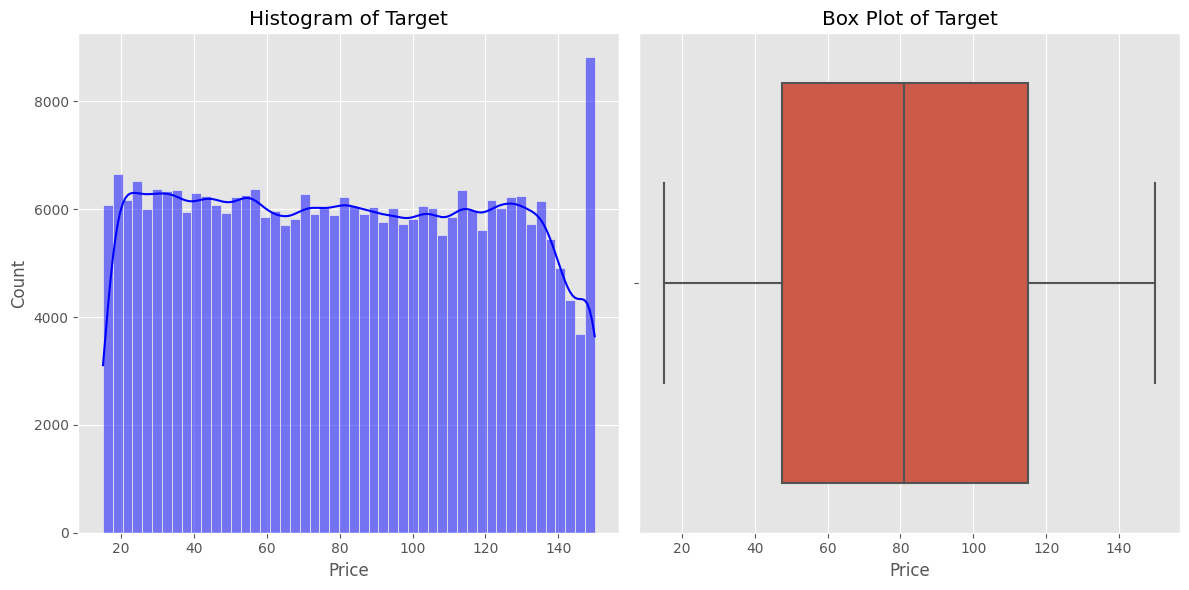

In [ ]:
plt.style.use('ggplot')
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.histplot(data=train_df, x='Price', bins=50, kde=True, color='blue',ax=ax[0])
ax[0].set_title('Histogram of Target')
sns.boxplot(data=train_df, x='Price', ax=ax[1])
ax[1].set_title('Box Plot of Target')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


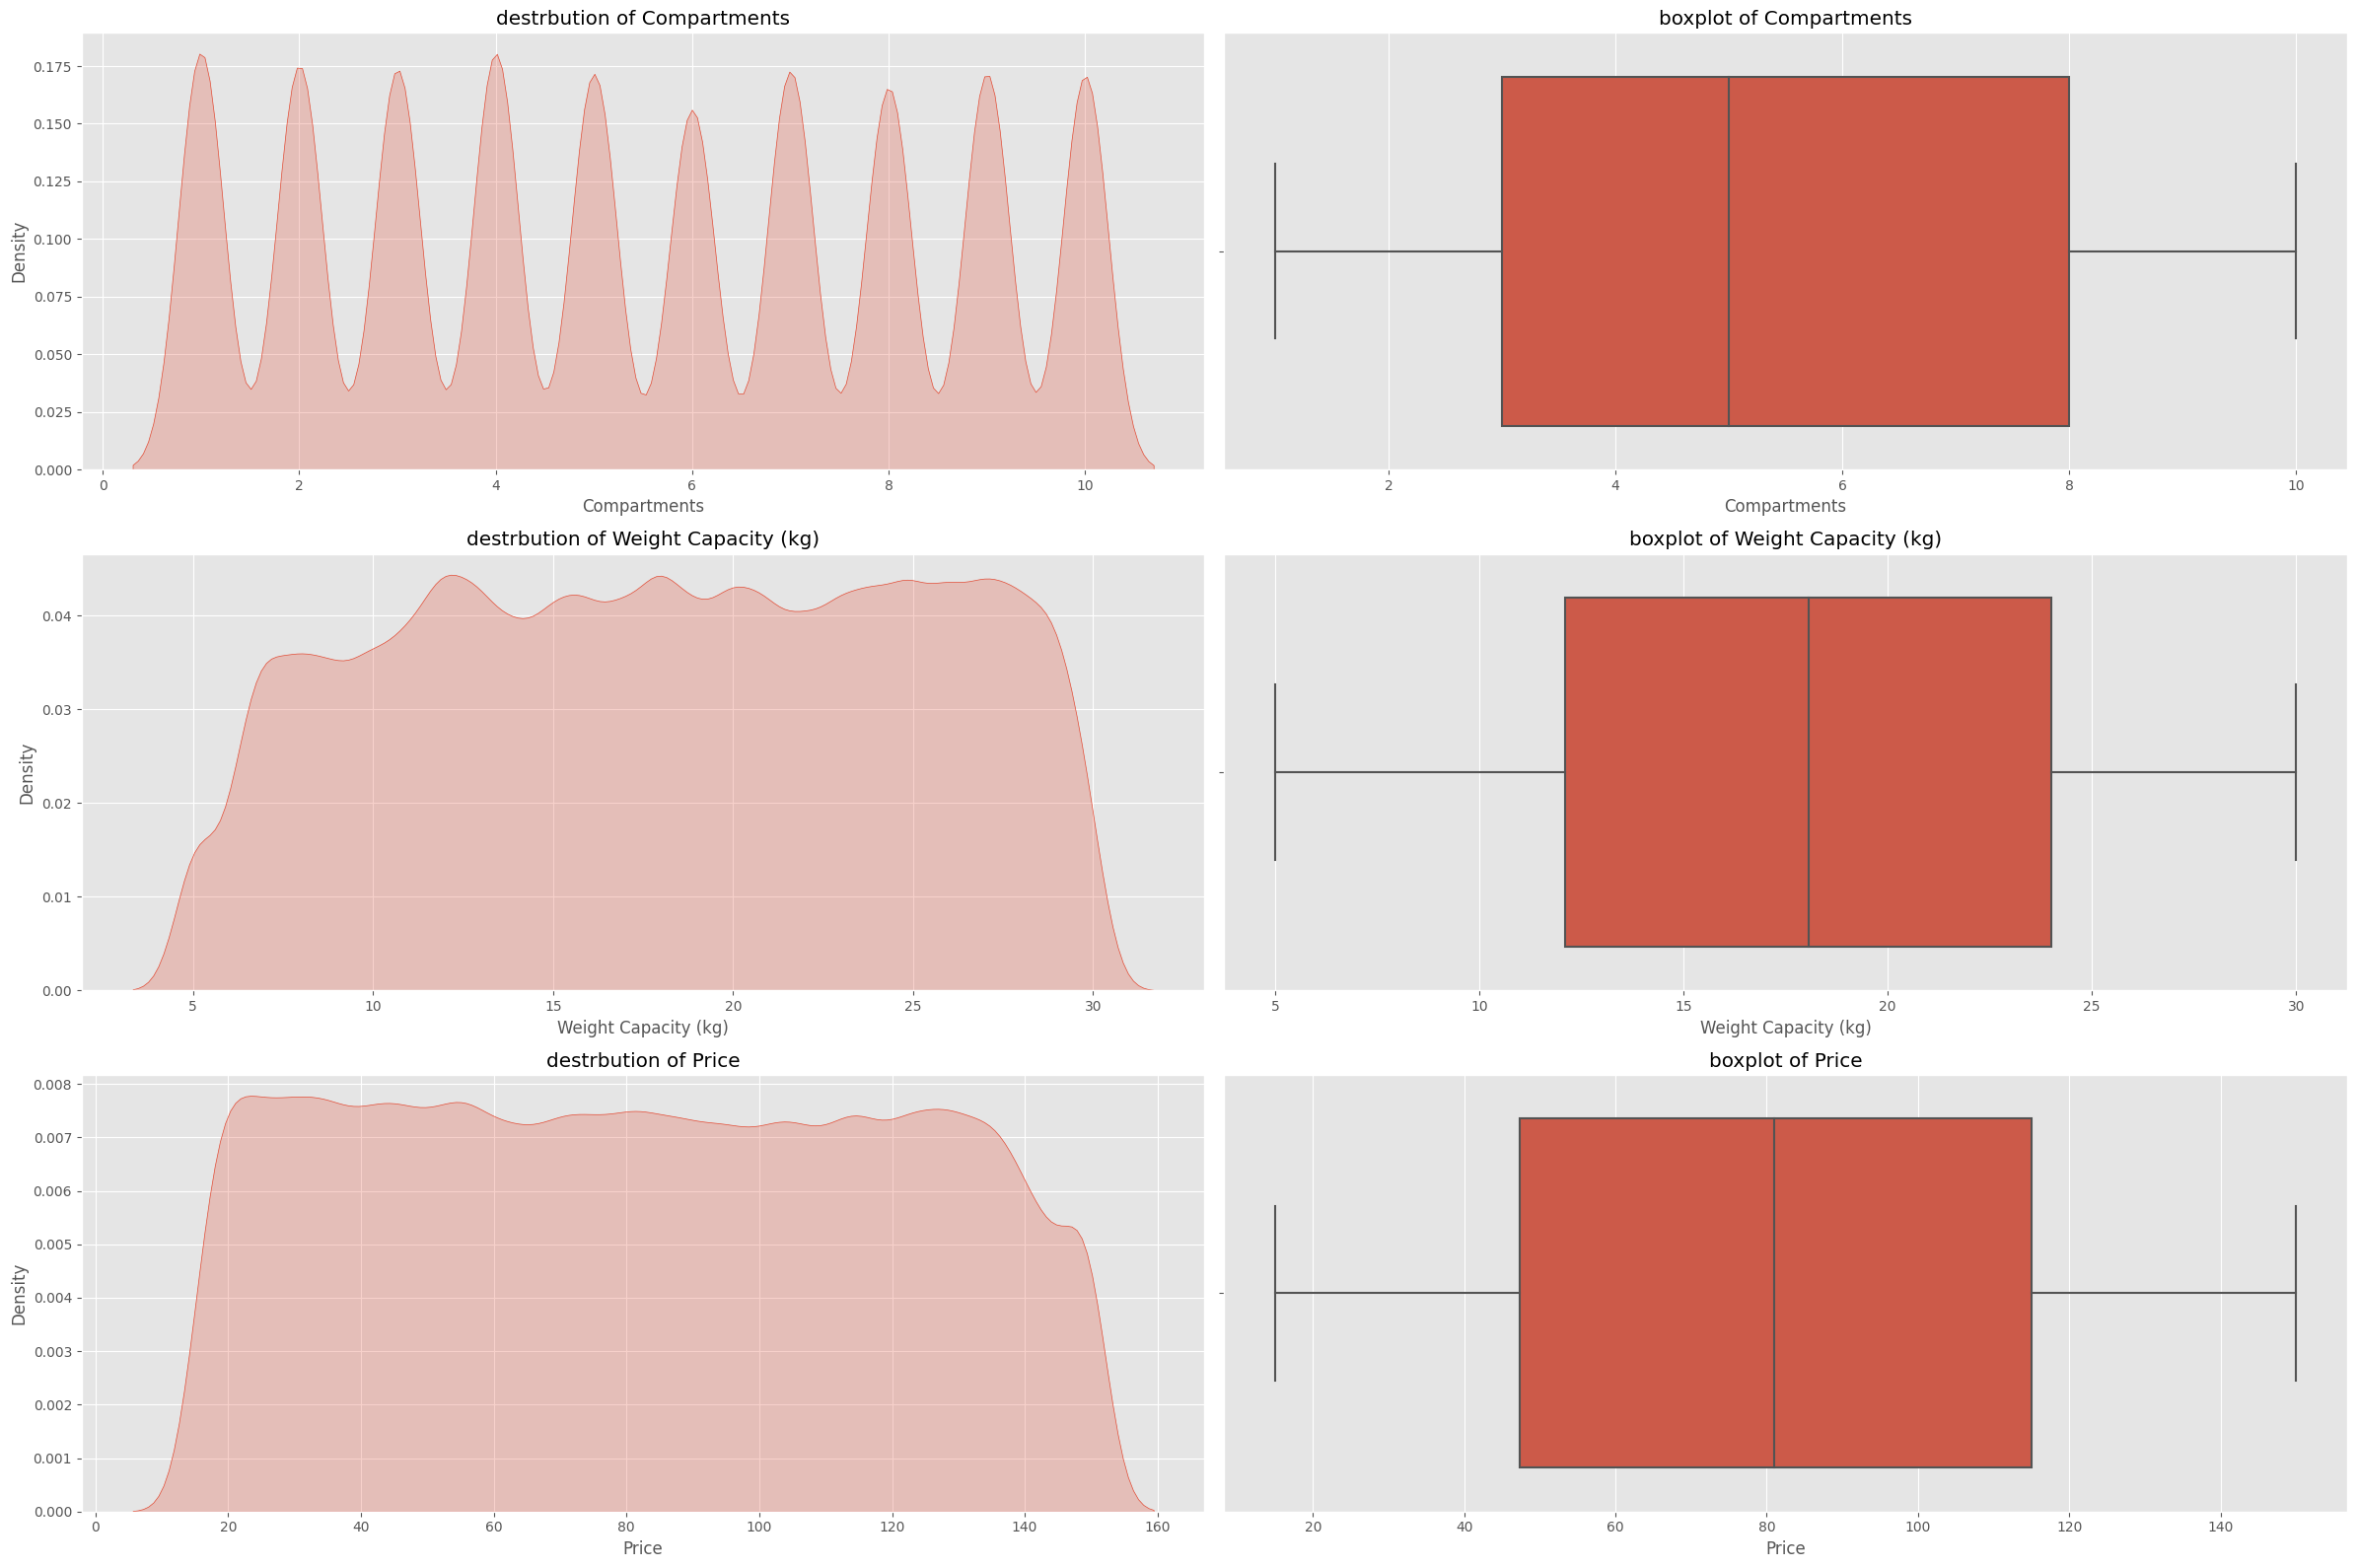

In [ ]:
fig ,ax = plt.subplots(len(num_col), 2, figsize=(24, 16))
for idx, i in enumerate(num_col):
    # kde plot
    sns.kdeplot(data=train_df, x=i, ax=ax[idx, 0], fill=True)
    ax[idx, 0].set_title('destrbution of {}'.format(i))
    ax[idx, 0].set(xlabel=i)
    # boxplot
    sns.boxplot(data=train_df, x=i, ax=ax[idx, 1])
    ax[idx, 1].set_title('boxplot of {}'.format(i))
plt.tight_layout()
plt.show()

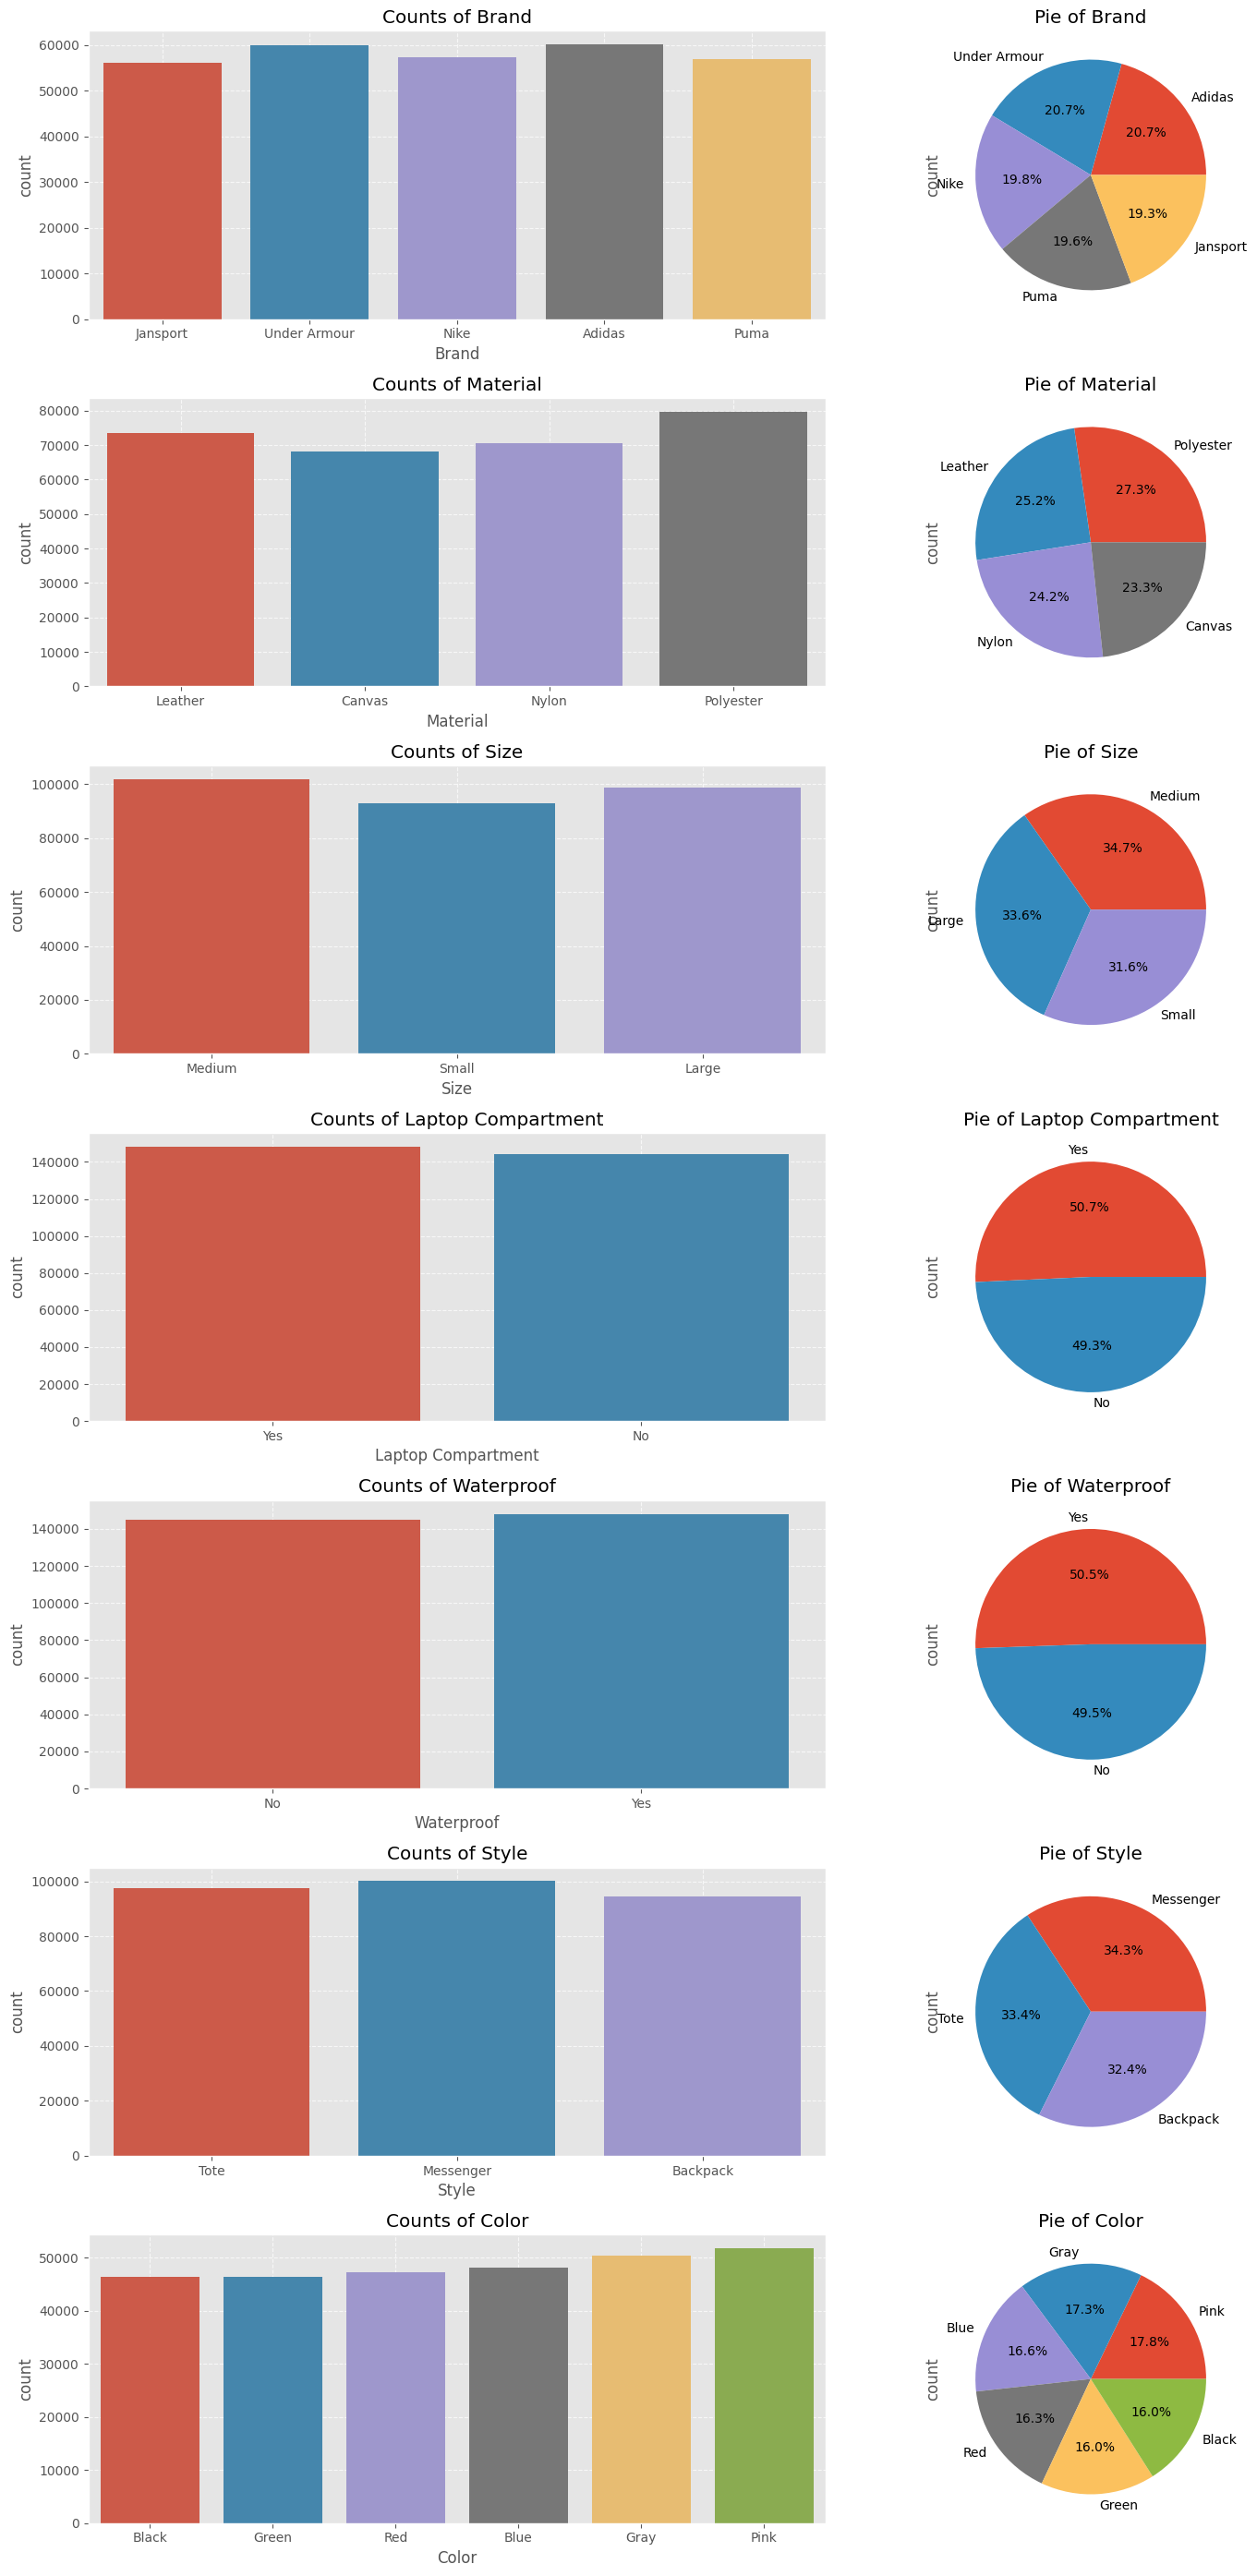

In [ ]:
# Identify categorical columns
cat_col = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Set up subplots
fig, ax = plt.subplots(len(cat_col), 2, figsize=(16, 4 * len(cat_col)))

# Ensure ax is always a 2D array
if len(cat_col) == 1:
    ax = [ax]

# Loop through each categorical column
for idx, col in enumerate(cat_col):
    # Bar Chart
    sns.countplot(data=train_df, x=col, ax=ax[idx][0])
    ax[idx][0].set_title(f'Counts of {col}')
    ax[idx][0].grid(True, linestyle='--', alpha=0.7)

    # Pie Chart (Handle Too Many Categories)
    train_df[col].value_counts().plot(kind='pie', ax=ax[idx][1], autopct='%1.1f%%')
    ax[idx][1].set_title(f'Pie of {col}')

# Adjust layout
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

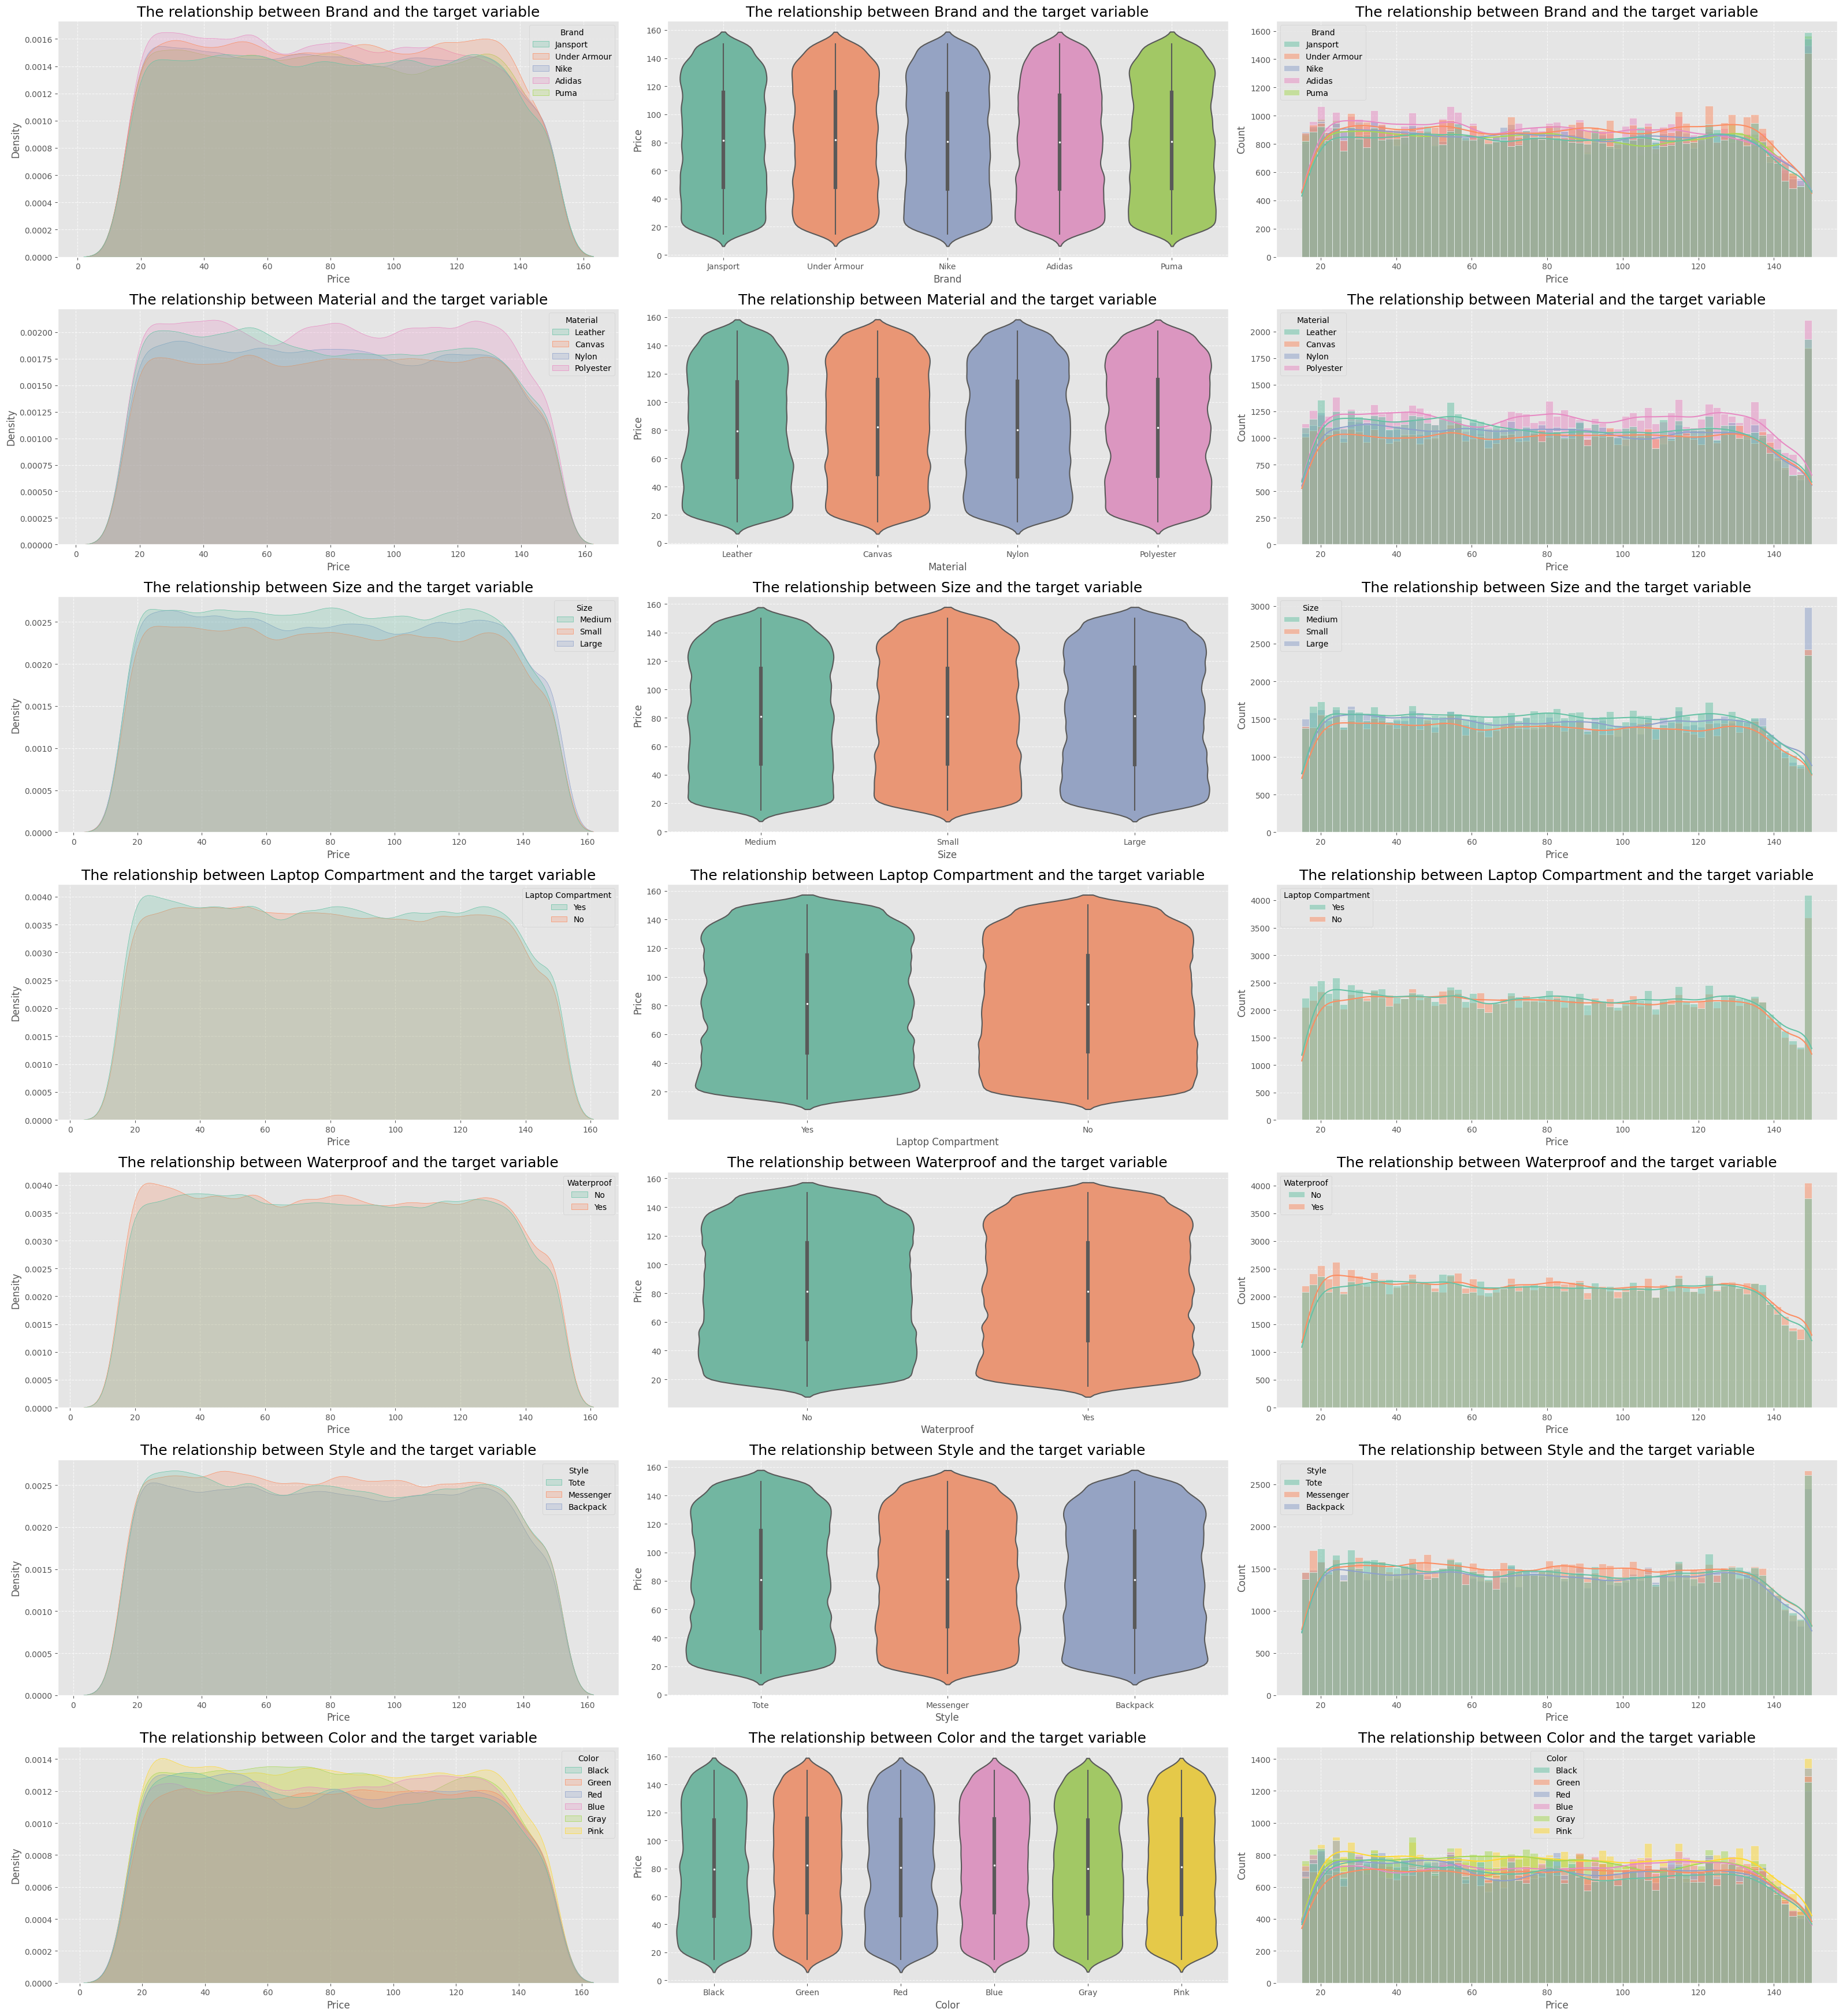

In [ ]:
# Identify categorical columns
cat_col = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Set up subplots
fig, axes = plt.subplots(len(cat_col), 3, figsize=(32, 5 * len(cat_col)))

# Ensure `axes` is always a 2D array
if len(cat_col) == 1:
    axes = [axes]

for i, col in enumerate(cat_col):
    # KDE Plot
    sns.kdeplot(x='Price', hue=col, data=train_df, ax=axes[i][0], palette='Set2', fill=True)
    axes[i][0].set_title(f'The relationship between {col} and the target variable', fontsize=18)
    axes[i][0].grid(True, linestyle='--', alpha=0.7)

    # Violin Plot
    sns.violinplot(x=col, y='Price', data=train_df, ax=axes[i][1], palette='Set2')
    axes[i][1].set_title(f'The relationship between {col} and the target variable', fontsize=18)
    axes[i][1].grid(True, linestyle='--', alpha=0.7)

    # Histogram with KDE
    sns.histplot(x='Price', hue=col, data=train_df, ax=axes[i][2], palette='Set2', kde=True)
    axes[i][2].set_title(f'The relationship between {col} and the target variable', fontsize=18)
    axes[i][2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
train_df.describe()


,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [ ]:
print(train_df.isnull().sum())


Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64


In [ ]:
train_df.dropna(inplace=True)


In [ ]:
from sklearn.preprocessing import LabelEncoder


encoders = {}

for col in cat_col:
    encoder = LabelEncoder()
    train_df[col] = encoder.fit_transform(train_df[col])
    encoders[col] = encoder  # Save encoder for future use

    # Encode test data, handling unseen labels
    test_labels = test_df[col].unique()
    train_labels = set(encoder.classes_)

    # Map unseen labels to -1
    test_df[col] = test_df[col].apply(lambda x: encoder.transform([x])[0] if x in train_labels else -1)

# Convert categorical columns to integer type
train_df[cat_col] = train_df[cat_col].astype(int)
test_df[cat_col] = test_df[cat_col].astype(int)

train_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,1,1,1,7.0,1,0,2,0,11.611723,112.15875
1,1,0,2,10.0,1,1,1,3,27.078537,68.88056
2,4,1,2,2.0,1,0,1,5,16.643760,39.17320
3,2,2,2,8.0,1,0,1,3,12.937220,80.60793
4,0,0,1,1.0,1,1,1,3,17.749338,86.02312


In [ ]:
X = train_df.drop('Price', axis=1)
y = train_df.Price
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Splitting the dataset
X = train_df.drop(columns=['Price'])  # Features
y = train_df['Price']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

score = {}

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
score['xgb'] = np.sqrt(mean_squared_error(y_test, y_pred))  # Using RMSE

# LightGBM Model
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
score['lgb'] = np.sqrt(mean_squared_error(y_test, y_pred))  # Using RMSE

print("RMSE Scores:", score)

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(score.keys(), score.values(), color='skyblue')
plt.title('Model Performance (RMSE)', fontsize=16)
plt.ylabel('RMSE')  # Correct label
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [ ]:
from sklearn.model_selection import KFold, GridSearchCV
import lightgbm as lgb
import numpy as np

# Define parameter grid (reduced for efficiency)
param_grid = {
    'n_estimators': [100, 300],  # Reduced search space
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'num_leaves': [31, 50],  # Should align with max_depth
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define GridSearchCV with RMSE scoring
grid_search = GridSearchCV(
    estimator=lgb.LGBMRegressor(),
    param_grid=param_grid,
    cv=kf,
    scoring='neg_root_mean_squared_error',  # Use RMSE instead of MSE
    n_jobs=-1,
    verbose=1
)

# Perform Grid Search
grid_search.fit(X, y)

# Best Parameters & RMSE Score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation RMSE: ", -grid_search.best_score_)

# Train model with best parameters
best_lgb_model = grid_search.best_estimator_
best_lgb_model.fit(X, y)

# Predict on test data
y_pred = best_lgb_model.predict(test_df)

# Evaluate Training Performance
y_train_pred = best_lgb_model.predict(X)
train_rmse = mean_squared_error(y, y_train_pred, squared=False)
print(f"Training RMSE: {train_rmse}")

In [ ]:
# Ensure no NaN values in predictions
pred = np.nan_to_num(best_lgb_model.predict(test_df))

# Create submission file
sub = pd.DataFrame({'id': sam.id, 'Price': pred})
sub.to_csv('submission.csv', index=False)

print("✅ Submission file 'submission.csv' saved successfully!")